# Process Mining Project
In this project we aim to compute predictions and, in case of a negative outcome prediction,
providing recommendations on the best activities to perform to achieve a positive outcome by
leveraging the transparency of decision trees.

## Data Loading and Preprocessing

### List of Imports

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import os
import src.utils as utils
import src.plotting as plotting
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Setting Up the Environment

In [2]:
TRAIN_LOG_PATH = os.path.join("logs", "Production_avg_dur_training_0-80.xes")
TEST_LOG_PATH = os.path.join("logs", "Production_avg_dur_testing_80-100.xes")

### Setting global parameters

In [3]:
prefix_length = 5

### Import the Event Logs
Import the event logs in XES format using the `pm4py` library.
Each trace in the log is then cut at a specified index to create prefixes for analysis.

In [4]:
log = utils.import_log(TRAIN_LOG_PATH)
print(f"Number of traces in the log: {len(log)}")
pruned_log = utils.create_prefixes_log(log, prefix_length=prefix_length)
print(f"\nFirst 5 traces:\n {pruned_log[:5]}")

parsing log, completed traces :: 100%|██████████| 177/177 [00:00<00:00, 447.74it/s]


Number of traces in the log: 177

First 5 traces:
 [{'attributes': {'concept:name': 'Case100', 'label': 'false'}, 'events': [{'Part_Desc_': 'Ballnut', 'Rework': 'missing', 'Work_Order_Qty': 18, 'Case ID': 'Case100', 'label': 'regular', 'Activity': 'Turning & Milling - Machine 8', 'Resource': 'ID4219', 'Report_Type': 'D', 'Resource.1': 'Machine 8 - Turning & Milling', 'Qty_Completed': 7, 'Qty_for_MRB': 0, 'activity_duration': 48.0, 'Complete Timestamp': Timestamp('2012-02-20 17:57:00+0000', tz='UTC'), 'timesincemidnight': 1077, 'month': 2, 'weekday': 0, 'hour': 17, 'timesincelastevent': 0.0, 'timesincecasestart': 0.0, 'event_nr': 1, 'open_cases': 28, 'concept:name': 'Turning & Milling - Machine 8', 'time:timestamp': Timestamp('2012-02-20 17:57:00+0000', tz='UTC'), '@@index': 26, '@@case_index': 2}, '..', {'Part_Desc_': 'Ballnut', 'Rework': 'missing', 'Work_Order_Qty': 18, 'Case ID': 'Case100', 'label': 'regular', 'Activity': 'Turning & Milling Q.C.', 'Resource': 'ID4618', 'Report_Type':

### Boolean Encoding
The event log is transformed into a boolean-encoded DataFrame where each column represents
the presence or absence of specific activities in the traces.

In [5]:
activity_names = utils.get_activity_names(log)
print(f"Unique activity names in the log: {activity_names}")
encoded_log = utils.boolean_encode(pruned_log, activity_names)
print(f"Encoded activities (first 5 cases):\n{encoded_log.head()}")

Unique activity names in the log: ['Turning & Milling - Machine 8', 'Turning & Milling Q.C.', 'Laser Marking - Machine 7', 'Flat Grinding - Machine 11', 'Lapping - Machine 1', 'Round Grinding - Machine 3', 'other', 'Final Inspection Q.C.', 'Packing', 'Round Grinding - Machine 2', 'Turning & Milling - Machine 5', 'Turning & Milling - Machine 10', 'Round Grinding - Q.C.', 'Turning - Machine 9', 'Turning Q.C.', 'Round Grinding - Manual', 'Turning & Milling - Machine 6', 'Turning - Machine 8', 'Turning & Milling - Machine 4', 'Round Grinding - Machine 12', 'Grinding Rework - Machine 27', 'Turning & Milling - Machine 9', 'Milling - Machine 16', 'Milling - Machine 14', 'Wire Cut - Machine 13', 'Turn & Mill. & Screw Assem - Machine 10']
Encoded activities (first 5 cases):
  trace_id  Turning & Milling - Machine 8  Turning & Milling Q.C.  \
0  Case100                           True                    True   
1  Case177                          False                   False   
2  Case142       

## Decision Tree 

**Taking optimized hyperparameters**

In [6]:
best_params = utils.hyperparameter_optimization(encoded_log, max_evals=100)

choosen_params = {
    'max_depth': 4,
    'max_features': 40,
    'criterion': 'gini',
    'random_state': 42
}

params = choosen_params  # You can switch to choosen_params if desired

100%|██████████| 100/100 [00:04<00:00, 20.90trial/s, best loss: -0.8273862622658341]
Best hyperparameters:
Max Depth: 290
Max Features: 26
Criterion: entropy


In [7]:
clf = DecisionTreeClassifier(max_depth=params['max_depth'], max_features=params['max_features'], criterion=params['criterion'], random_state=params['random_state'])
clf.fit(encoded_log.drop(['trace_id', 'label'], axis=1), encoded_log['label'])

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",40
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node

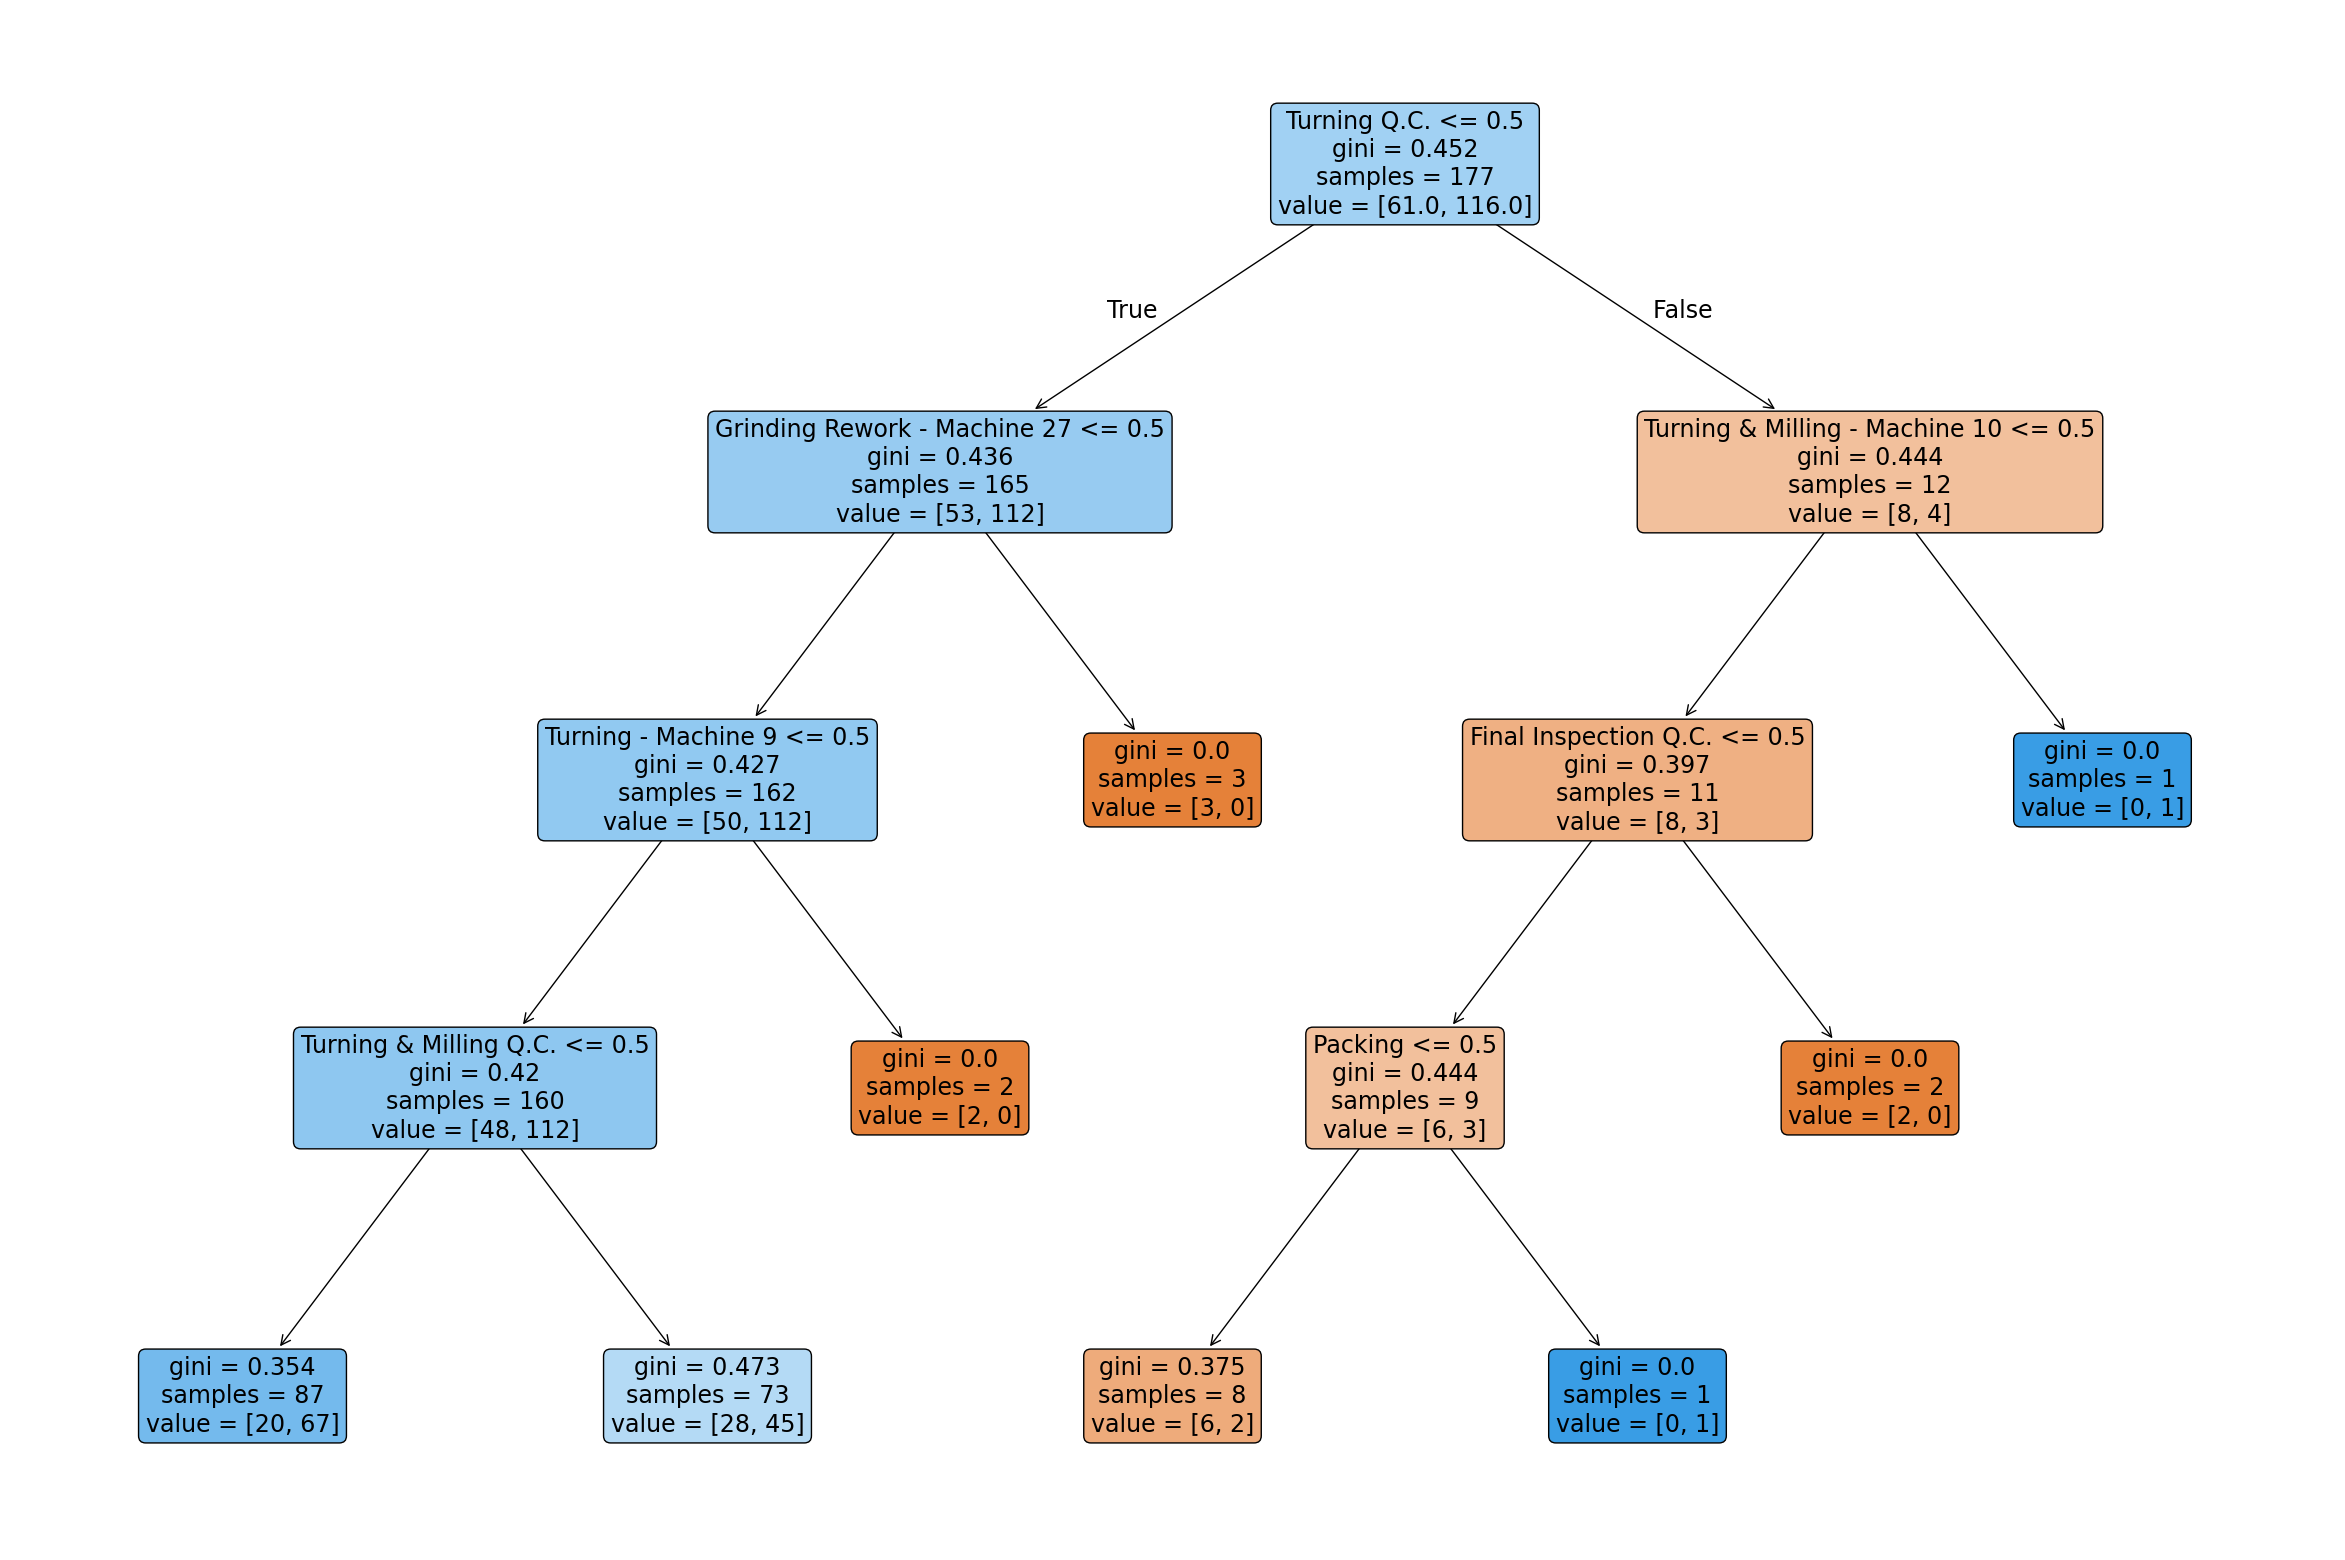

In [8]:
plotting.plot_decision_tree(clf, activity_names)

### Evaluation

**Importing testing set**

In [9]:
test_log = utils.import_log(TEST_LOG_PATH)
# Create prefixes for the test log as well
test_log = utils.create_prefixes_log(test_log, prefix_length=prefix_length)
test_encoded_log = utils.boolean_encode(test_log, activity_names)
predictions = clf.predict(test_encoded_log.drop(['trace_id', 'label'], axis=1))

parsing log, completed traces :: 100%|██████████| 43/43 [00:00<00:00, 438.48it/s]


**Confusion Matrix**

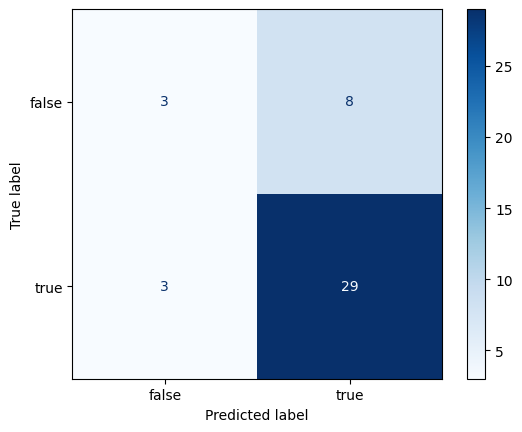

In [10]:
true_labels = test_encoded_log['label'].values
plotting.plot_confusion_matrix(true_labels, predictions)

**Metrics**

In [11]:
result = plotting.compute_all_metrics(true_labels, predictions)

Accuracy: 74.42%
Precision: 71.12%
Recall: 74.42%
F1-Measure: 71.58%


## Recommendations

**Extract recommendations from the decision tree**

In [12]:
test_encoded_log_with_predictions = test_encoded_log.copy().drop('label', axis=1)
test_encoded_log_with_predictions['predicted_label'] = predictions
recommendations = utils.extract_recommendations(clf, activity_names, test_encoded_log_with_predictions)

Prefix Trace: {'Round Grinding - Machine 2', 'Round Grinding - Machine 3', 'Grinding Rework - Machine 27', 'Lapping - Machine 1'} -> Recommended Activities: {('Packing', True), ('Final Inspection Q.C.', False), ('Turning & Milling - Machine 10', False), ('Turning Q.C.', True)}
Prefix Trace: {'other', 'Grinding Rework - Machine 27', 'Final Inspection Q.C.', 'Packing'} -> Recommended Activities: {('Turning & Milling - Machine 10', True), ('Turning Q.C.', True)}
Prefix Trace: {'other', 'Grinding Rework - Machine 27', 'Final Inspection Q.C.'} -> Recommended Activities: {('Turning & Milling - Machine 10', True), ('Turning Q.C.', True)}
Prefix Trace: {'Turning Q.C.', 'Turning & Milling - Machine 8'} -> Recommended Activities: {('Packing', True), ('Turning & Milling - Machine 10', False), ('Final Inspection Q.C.', False)}
Prefix Trace: {'Turning Q.C.', 'Turning & Milling - Machine 9'} -> Recommended Activities: {('Packing', True), ('Turning & Milling - Machine 10', False), ('Final Inspection 

**Evaluation recommendations**

In [ ]:
evaluation_metrics = utils.evaluate_recommendations(test_encoded_log, recommendations)
plotting.print_recommendations_metrics(evaluation_metrics)

Recommendations Evaluation Metrics:
Precision: 0.00%
Recall: 0.00%
Accuracy: 0.00%
F1_score: 0.00%
